In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

/home/jcthompson5@ad.wisc.edu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


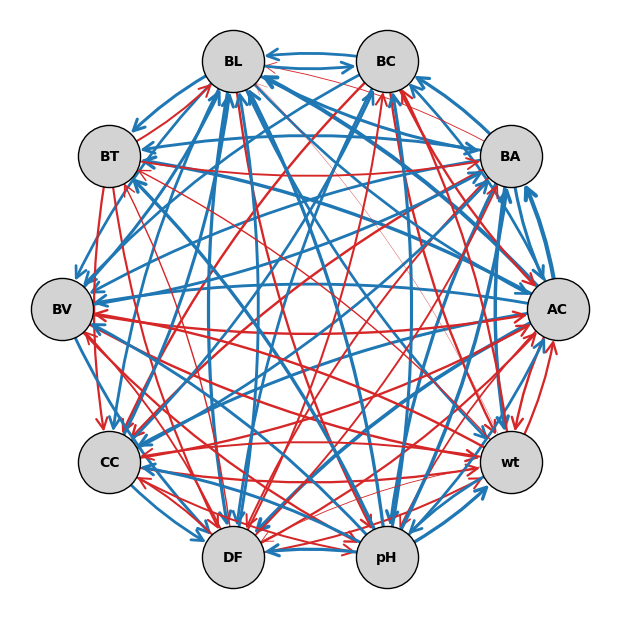

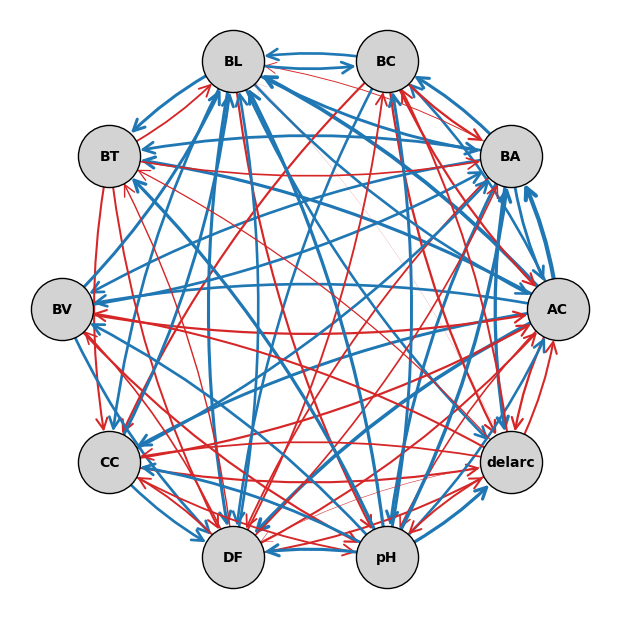

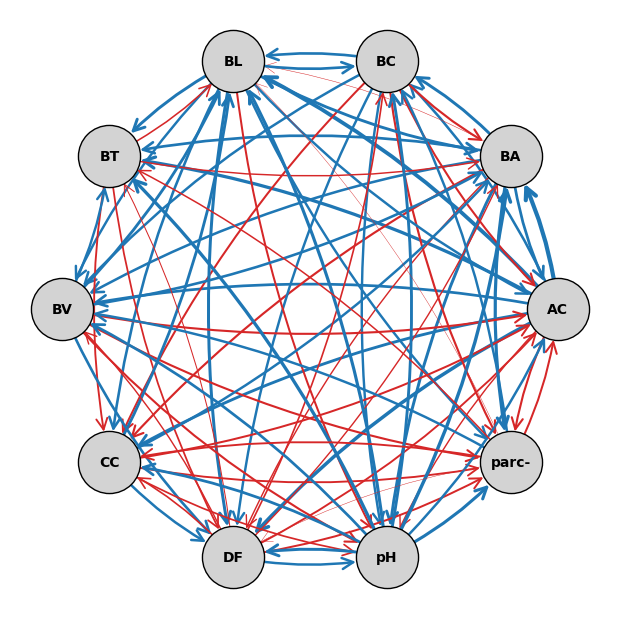

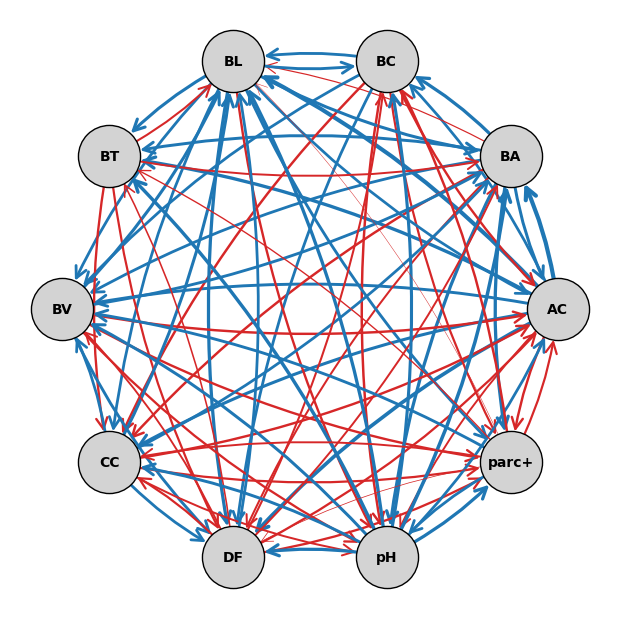

In [2]:
# species that aren't ecoli
not_ecoli = ['AC_OD', 'BA_OD', 'BC_OD', 'BL_OD', 'BT_OD', 'BV_OD', 'CC_OD', 'DF_OD', 'pH']

# set of ecoli strains
ecoli_strains =  ['wt_OD', 'delarc_OD', 'parc-_OD', 'parc+_OD']

# min and max (scaled) pH
pH_min = .4
pH_max = .6

# loop over ecoli strains
for ecoli_strain in ecoli_strains:

    # species + single ecoli strain
    species_and_strain = not_ecoli + [ecoli_strain]

    # init network btw species and pH
    S2S = np.zeros([len(species_and_strain), len(species_and_strain)])
    
    # loop over receiver strains
    for i, receiver in enumerate(species_and_strain):
    
        # import SHAP values 
        int_df = pd.read_csv(f"insights/{ecoli_strain}/{receiver}_shap.csv")
        
        # consider nominal pH conditions
        pH_vals = int_df['pH'].values
        pH_inds = (pH_min < pH_vals) & (pH_vals < pH_max)
        int_df = int_df.iloc[pH_inds].copy()
        
        # loop over effector strains
        for j, effector in enumerate(species_and_strain):

            # only consider samples with both receiver and effector species present
            receiver_design = int_df[receiver].values
            effector_design = int_df[effector].values
            interaction = int_df[f"{receiver}<--{effector}"].values[(receiver_design>0) & (effector_design>0)]

            # save average interaction
            S2S[i,j] = np.mean(interaction)
            
    # Create a directed graph
    G = nx.DiGraph()

    # add nodes
    s_names = [s.split("_")[0] for s in species_and_strain]
    G.add_nodes_from(s_names)

    # min required magnitude to show edge
    edge_min = .025

    # Add edges connecting species to species
    for i, receiver in enumerate(s_names):
        for j, effector in enumerate(s_names):
            if i != j:
                if np.abs(S2S[i, j]) > edge_min:
                    if S2S[i, j] > 0:
                        G.add_edge(effector, receiver, width=S2S[i, j], color='tab:blue')
                    else:
                        G.add_edge(effector, receiver, width=S2S[i, j], color='tab:red')

    # Draw the graph with labeled nodes and edges
    pos = nx.circular_layout(G)

    # Get edge weights for drawing edge widths
    edge_max = max([G[u][v]['width'] for (u, v) in G.edges()])
    edge_min = min([G[u][v]['width'] for (u, v) in G.edges()])

    # set edge widths, node sizes, and arrow sizes
    edge_set_max = 3
    edge_set_min = 0
    widths = [(G[u][v]['width'] - edge_min) / (edge_max - edge_min) * (edge_set_max - edge_set_min) + edge_set_min
              for (u, v) in G.edges()]

    # Draw the network graph
    plt.figure(figsize=(6, 6))
    nx.draw(G, pos, 
            with_labels=True, 
            node_size=2000, 
            node_color='lightgray',
            edgecolors='black',
            font_size=10, 
            font_weight='bold',
            font_color='black', 
            arrowsize=20, 
            connectionstyle='arc3, rad=.1',
            arrowstyle='->',
            width=widths, 
            min_source_margin=10,
            edge_color=[G[u][v]['color'] for u, v in G.edges()],
            edge_cmap=plt.cm.Greys)
    plt.axis('off')

    # plt.savefig(f"figures/slides/glv_net_VI.png", dpi=300)
    plt.show()

In [4]:
int_df

,Experiments,parc+_OD<--AC_OD,parc+_OD<--BA_OD,parc+_OD<--BC_OD,parc+_OD<--BL_OD,parc+_OD<--BT_OD,parc+_OD<--BV_OD,parc+_OD<--CC_OD,parc+_OD<--DF_OD,parc+_OD<--parc+_OD,...,BL_OD,BT_OD,BV_OD,CC_OD,DF_OD,wt_OD,delarc_OD,parc-_OD,parc+_OD,pH
8,7comm11parc_1,-0.041011,0.168047,-0.101336,0.066545,-0.006535,-0.056201,-0.086045,-0.073760,0.555957,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.547737
9,7comm11parc_2,-0.042070,0.168992,-0.092979,0.069293,-0.005557,-0.050614,-0.092915,-0.077100,0.546043,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.547737
10,7comm11parc_3,-0.044753,0.169989,-0.104561,0.069874,0.000285,-0.048834,-0.091574,-0.061502,0.544318,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.547737
11,7comm11parc_4,-0.039592,0.159667,-0.079064,0.067079,0.006676,-0.047701,-0.090163,-0.078351,0.548880,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.547737
25,parc+_pH7_0,0.027436,-0.078733,0.030328,-0.037251,-0.005190,0.027995,0.050080,0.020460,0.616733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.592207
26,parc+_pH7_1,0.027985,-0.070801,0.031939,-0.038145,-0.004811,0.026547,0.042621,0.019474,0.615844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.548097
27,parc+_pH7_2,0.028312,-0.075853,0.032311,-0.038867,-0.006031,0.030620,0.043613,0.018253,0.613093,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.546912
43,AC_pH7_0,-0.008855,-0.018301,0.009499,-0.007292,-0.000405,0.004268,0.007791,0.009456,-0.116668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.476157
44,AC_pH7_1,-0.008564,-0.015277,0.008177,-0.007606,0.000473,0.003660,0.009680,0.007806,-0.118240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.482267
45,AC_pH7_2,-0.008404,-0.017314,0.008882,-0.008670,0.000926,0.005938,0.007429,0.009983,-0.117990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.481103
